In [5]:
# Load Data
import pandas as pd
afl_df = pd.read_csv('afl_stats2.csv')
afl_df = afl_df[afl_df['Winner'] != 'Draw']

## Data exploration

In [8]:
afl_df.head()

,Game,Season,Date,Round,HomeTeam,AwayTeam,Winner,SeasonPointsBy,SeasonPointsAgainst,SeasonPerformance,...,Performance_Last_2,PointsBy_Last_3,PointsAgainst_Last_3,Performance_Last_3,PointsBy_Last_4,PointsAgainst_Last_4,Performance_Last_4,PointsBy_Last_5,PointsAgainst_Last_5,Performance_Last_5
0,11728,2000,2000-03-08,R1,Richmond,Melbourne,Home,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11729,2000,2000-03-09,R1,Essendon,Port Adelaide,Home,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11730,2000,2000-03-10,R1,North Melbourne,West Coast,Away,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11731,2000,2000-03-11,R1,Adelaide,Geelong,Away,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11732,2000,2000-03-11,R1,Fremantle,Footscray,Away,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
afl_df.shape

(4425, 26)

In [10]:
afl_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4425 entries, 0 to 4462
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Game                  4425 non-null   int64  
 1   Season                4425 non-null   int64  
 2   Date                  4425 non-null   object 
 3   Round                 4425 non-null   object 
 4   HomeTeam              4425 non-null   object 
 5   AwayTeam              4425 non-null   object 
 6   Winner                4425 non-null   object 
 7   SeasonPointsBy        4425 non-null   float64
 8   SeasonPointsAgainst   4425 non-null   float64
 9   SeasonPerformance     4425 non-null   float64
 10  Ranking               4425 non-null   float64
 11  PointsBy_Last_1       4415 non-null   float64
 12  PointsAgainst_Last_1  4415 non-null   float64
 13  Performance_Last_1    4415 non-null   float64
 14  PointsBy_Last_2       4415 non-null   float64
 15  PointsAgainst_Last_2 

There will be 8 missing values in each of the 'rolling average' statistics, because this cannot be calculated for the very first round.
There are two additional missing values: this is because two new teams were added to the AFL.
Gold Coast Suns were added in 2011 and Greater Western Sydney was added in 2012.

In [12]:
afl_df.describe()

,Game,Season,SeasonPointsBy,SeasonPointsAgainst,SeasonPerformance,Ranking,PointsBy_Last_1,PointsAgainst_Last_1,Performance_Last_1,PointsBy_Last_2,...,Performance_Last_2,PointsBy_Last_3,PointsAgainst_Last_3,Performance_Last_3,PointsBy_Last_4,PointsAgainst_Last_4,Performance_Last_4,PointsBy_Last_5,PointsAgainst_Last_5,Performance_Last_5
count,4425.000000,4425.000000,4425.000000,4425.000000,4425.000000,4425.000000,4415.000000,4415.000000,4415.000000,4415.000000,...,4415.000000,4415.000000,4415.000000,4415.000000,4415.000000,4415.000000,4415.000000,4415.000000,4415.000000,4415.000000
mean,13959.683390,2011.237062,2.040452,-3.402486,0.070508,0.003842,-4.161042,3.477690,-0.145413,-1.584371,...,-0.047792,-1.306493,1.237637,-0.049830,-0.785428,0.567629,-0.024802,-0.710457,0.508932,-0.022288
std,1288.738096,6.603234,202.365851,208.685187,7.131071,2.801968,37.961462,37.783172,1.410576,28.463664,...,1.038554,24.552735,25.453474,0.896346,22.041580,23.316744,0.806170,20.421526,21.892228,0.744296
min,11728.000000,2000.000000,-990.000000,-1137.000000,-32.000000,-10.000000,-136.000000,-186.000000,-2.000000,-112.000000,...,-2.000000,-96.333333,-104.333333,-2.000000,-87.250000,-94.250000,-2.000000,-85.200000,-77.200000,-2.000000
25%,12842.000000,2006.000000,-100.000000,-100.000000,-4.000000,-2.000000,-29.000000,-21.000000,-2.000000,-20.250000,...,-1.000000,-17.666667,-15.333333,-0.666667,-15.250000,-14.250000,-0.500000,-14.400000,-13.600000,-0.400000
50%,13963.000000,2012.000000,0.000000,0.000000,0.000000,0.000000,-5.000000,3.000000,0.000000,-1.000000,...,0.000000,-1.333333,1.333333,0.000000,-0.750000,0.500000,0.000000,-0.600000,0.800000,0.000000
75%,15074.000000,2017.000000,98.000000,93.000000,4.000000,2.000000,21.000000,28.000000,0.000000,17.000000,...,1.000000,15.333333,17.666667,0.666667,14.000000,15.750000,0.500000,12.800000,14.400000,0.400000
max,16190.000000,2022.000000,1053.000000,1095.000000,36.000000,10.000000,186.000000,130.000000,2.000000,110.500000,...,2.000000,80.333333,98.333333,2.000000,72.500000,97.250000,2.000000,80.600000,90.000000,2.000000


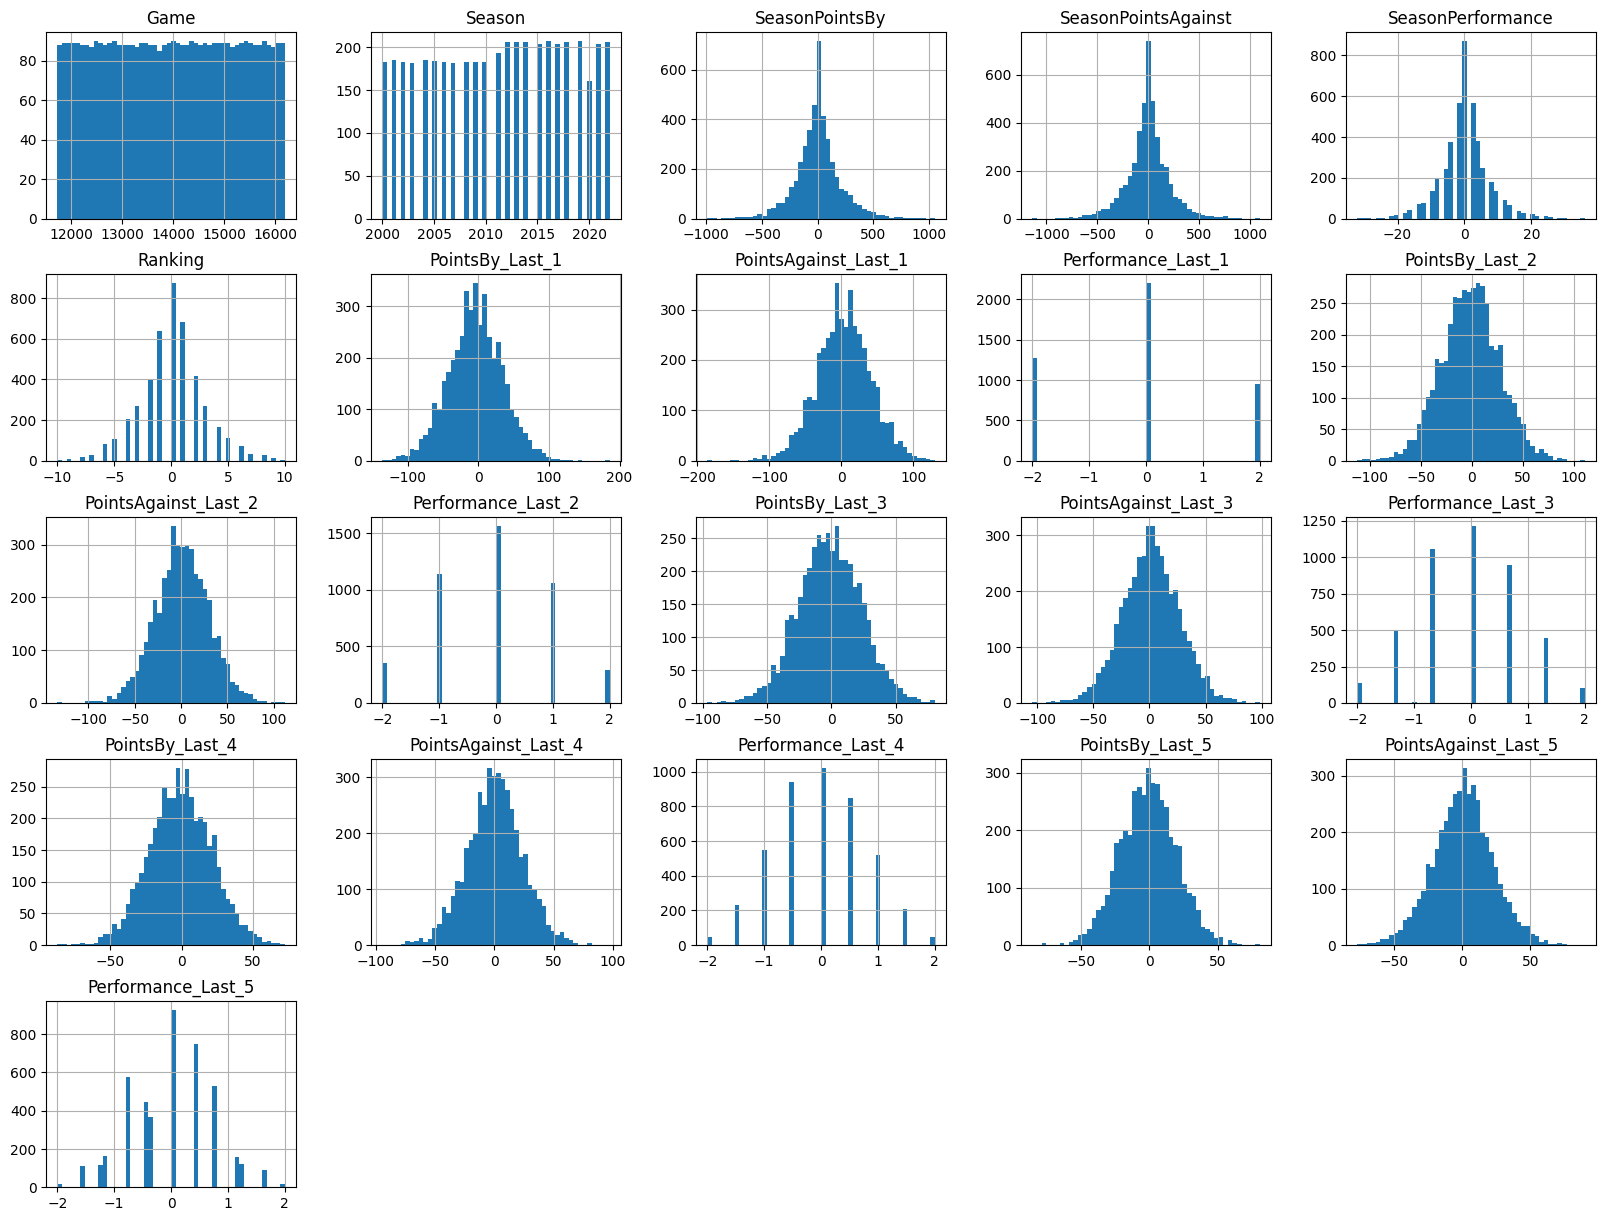

In [13]:
import matplotlib.pyplot as plt
afl_df.hist(bins=50, figsize=(20,15))
plt.show()

The variables are normally distributed. 

The seasonal points have higher values, because it's a cumulative sum and no average is taken.

In 2020 we see the effect of COVID-19; less games were played that year.

## Create training and test set

In [14]:
# Create a training and test set.
# Use games played before 2019 as the training set.
train_set = afl_df[afl_df['Season'] < 2019]
train_labels = train_set["Winner"]
test_set = afl_df[afl_df['Season'] >= 2019]

## Data preparation

In [18]:
afl_features = train_set.drop("Winner", axis = 1)

In [16]:
from sklearn import set_config
set_config(transform_output = "pandas")

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

# Indices are for after 'Winner' has been dropped
game_ix, season_ix, date_ix, round_ix, hometeam_ix, awayteam_ix = 0, 1, 2, 3, 4, 5
cols_to_drop = [game_ix, season_ix, date_ix, round_ix, hometeam_ix, awayteam_ix]

class AFLDataPrepper(BaseEstimator, TransformerMixin):
    def __init__(self, dropNA = True):
        self.dropNA = dropNA

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        # Convert date to datetime format
        X[X.columns[date_ix]] = pd.to_datetime(X[X.columns[date_ix]])

        # Only want to use features that we can know before the game is played
        X = X.drop(X.columns[cols_to_drop], axis=1)

        # Remove rows with missing values
        if self.dropNA:
            X = X.dropna()

        return X    


In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

afl_pipeline = Pipeline([
    ('afl_prepper', AFLDataPrepper()),
    ('std_scaler', StandardScaler())
])


In [23]:
afl_prepared = afl_pipeline.fit_transform(afl_features)

In [24]:
# Need to drop NA values before taking the labels
train_labels = train_set.dropna()["Winner"]

### Selecting and training a model

In [25]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
import numpy as np

def evaluate_model(model, train, labels, k=3):
    accuracy = cross_val_score(model, train, labels, cv=k, scoring = "accuracy")
    print("Accuracy = {:0.2f}%".format(np.mean(accuracy)*100))


#### Random Forest Classifier

In [16]:
from sklearn.ensemble import RandomForestClassifier
afl_rf = RandomForestClassifier()

In [17]:
afl_rf.fit(afl_prepared, train_labels)

RandomForestClassifier()

In [18]:
evaluate_model(afl_rf, afl_prepared, train_labels)

Accuracy = 65.04%


In [21]:
# Fine tune the parameters with a gridsearch or randomised grid search - but might need to take a smaller sample.

#### Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=500)
log_reg.fit(afl_prepared, train_labels)

LogisticRegression(max_iter=500)

In [23]:
evaluate_model(log_reg, afl_prepared, train_labels)

Accuracy = 65.17%


So, out of the box this seems to at least do as well as the random forest classifier.

#### Support Vector Machine

In [24]:
from sklearn.svm import LinearSVC
linearSVC = LinearSVC(C=0.001, loss='hinge')

In [25]:
evaluate_model(linearSVC, afl_prepared, train_labels)

Accuracy = 65.92%


In [26]:
# Polynomial SVM
from sklearn.svm import SVC
poly_svm = SVC(kernel = "poly", degree=3, C=0.0001)
evaluate_model(poly_svm, afl_prepared, train_labels)

Accuracy = 58.05%


So higher degree polynomials don't appear to do a better job.

#### Neural networks

In [140]:
import tensorflow as tf 
from tensorflow import keras


In [141]:
model = keras.Sequential([
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(learning_rate=0.03),
    metrics=[
        keras.metrics.BinaryAccuracy(name='accuracy'),
    ]
)

In [97]:
bin_labels = (train_labels == "Home").astype('int')

In [142]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [147]:
tf.random.set_seed(42)
history = model.fit(afl_prepared, bin_labels, epochs=100, validation_split=0.2, callbacks=[early_stopping_cb])

Epoch 1/100


C:\Users\tomdo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\keras\engine\data_adapter.py:1700: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


91/91 [==============================] - 1s 4ms/step - loss: 0.5912 - accuracy: 0.6818 - val_loss: 0.6520 - val_accuracy: 0.6538
Epoch 2/100
91/91 [==============================] - 0s 2ms/step - loss: 0.5862 - accuracy: 0.6955 - val_loss: 0.6588 - val_accuracy: 0.6456
Epoch 3/100
91/91 [==============================] - 0s 2ms/step - loss: 0.5888 - accuracy: 0.6883 - val_loss: 0.6290 - val_accuracy: 0.6484
Epoch 4/100
91/91 [==============================] - 0s 2ms/step - loss: 0.5906 - accuracy: 0.6670 - val_loss: 0.6318 - val_accuracy: 0.6566
Epoch 5/100
91/91 [==============================] - 0s 3ms/step - loss: 0.5788 - accuracy: 0.6900 - val_loss: 0.6400 - val_accuracy: 0.6374
Epoch 6/100
91/91 [==============================] - 0s 3ms/step - loss: 0.5805 - accuracy: 0.6997 - val_loss: 0.6270 - val_accuracy: 0.6264
Epoch 7/100
91/91 [==============================] - 0s 3ms/step - loss: 0.5812 - accuracy: 0.6959 - val_loss: 0.6344 - val_accuracy: 0.6456
Epoch 8/100
91/91 [======

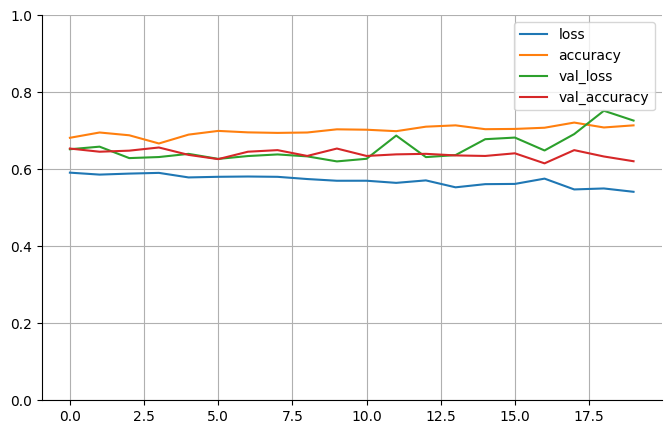

In [148]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [188]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(38,)))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    optimizer = keras.optimizers.Adam(learning_rate)
    model.compile(loss=keras.losses.binary_crossentropy, optimizer=optimizer)
    return model

In [193]:
from scikeras.wrappers import KerasClassifier

keras_clf = KerasClassifier(
    model=build_model,
    n_hidden=1,
    n_neurons=30,
    learning_rate = 3e-3
)

In [223]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [1,2,3,4],
    "n_neurons": [10,20,30],
    "learning_rate": reciprocal(3e-4, 3e-2)
}
rnd_search_cv = RandomizedSearchCV(keras_clf, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(afl_prepared, bin_labels, epochs=100,
                  validation_split=0.2,
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)],
                  verbose=0)


38/38 [==============================] - 0s 2ms/step


RandomizedSearchCV(cv=3,
                   estimator=KerasClassifier(learning_rate=0.003, model=<function build_model at 0x000001D50C68D4C0>, n_hidden=1, n_neurons=30),
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001D50A9EB550>,
                                        'n_hidden': [1, 2, 3, 4],
                                        'n_neurons': [10, 20, 30]})

In [225]:
best_model = rnd_search_cv.best_estimator_.model_
best_model.save("my_keras_model.h5")
rnd_search_cv.best_params_

{'learning_rate': 0.0007357777707066484, 'n_hidden': 1, 'n_neurons': 30}

In [226]:
evaluate_model(rnd_search_cv.best_estimator_, afl_prepared, bin_labels)

38/38 [==============================] - 0s 1ms/step
Accuracy = 64.51%


In [227]:
evaluate_model(KerasClassifier(model=build_model, n_hidden=1), afl_prepared, bin_labels)

38/38 [==============================] - 0s 1ms/step
Accuracy = 64.40%
